En este Notebook voy a hacer prácticamente el mismo ejercicio realizado que en el anterior Notebook, pero únicamente voy a utilizar el método de regresión xgboost y voy a coger pocas variables y compararlo con lo que me salió.

El objetivo es ver si me aproximo o mejor el error:

El error por mínimo cuadrados que me salía era de 2893.38039572 $ de media por casa

# House Prices Predictions

Los datos son cogidos del siguiente kaggle: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

Here's a brief version of what you'll find in the data description file.

* SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.
* MSSubClass: The building class
* MSZoning: The general zoning classification
* LotFrontage: Linear feet of street connected to property
* LotArea: Lot size in square feet
* Street: Type of road access
* Alley: Type of alley access
* LotShape: General shape of property
* LandContour: Flatness of the property
* Utilities: Type of utilities available
* LotConfig: Lot configuration
* LandSlope: Slope of property
* Neighborhood: Physical locations within Ames city limits
* Condition1: Proximity to main road or railroad
* Condition2: Proximity to main road or railroad (if a second is present)
* BldgType: Type of dwelling
* HouseStyle: Style of dwelling
* OverallQual: Overall material and finish quality
* OverallCond: Overall condition rating
* YearBuilt: Original construction date
* YearRemodAdd: Remodel date
* RoofStyle: Type of roof
* RoofMatl: Roof material
* Exterior1st: Exterior covering on house
* Exterior2nd: Exterior covering on house (if more than one material)
* MasVnrType: Masonry veneer type
* MasVnrArea: Masonry veneer area in square feet
* ExterQual: Exterior material quality
* ExterCond: Present condition of the material on the exterior
* Foundation: Type of foundation
* BsmtQual: Height of the basement
* BsmtCond: General condition of the basement
* BsmtExposure: Walkout or garden level basement walls
* BsmtFinType1: Quality of basement finished area
* BsmtFinSF1: Type 1 finished square feet
* BsmtFinType2: Quality of second finished area (if present)
* BsmtFinSF2: Type 2 finished square feet
* BsmtUnfSF: Unfinished square feet of basement area
* TotalBsmtSF: Total square feet of basement area
* Heating: Type of heating
* HeatingQC: Heating quality and condition
* CentralAir: Central air conditioning
* Electrical: Electrical system
* 1stFlrSF: First Floor square feet
* 2ndFlrSF: Second floor square feet
* LowQualFinSF: Low quality finished square feet (all floors)
* GrLivArea: Above grade (ground) living area square feet
* BsmtFullBath: Basement full bathrooms
* BsmtHalfBath: Basement half bathrooms
* FullBath: Full bathrooms above grade
* HalfBath: Half baths above grade
* Bedroom: Number of bedrooms above basement level
* Kitchen: Number of kitchens
* KitchenQual: Kitchen quality
* TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
* Functional: Home functionality rating
* Fireplaces: Number of fireplaces
* FireplaceQu: Fireplace quality
* GarageType: Garage location
* GarageYrBlt: Year garage was built
* GarageFinish: Interior finish of the garage
* GarageCars: Size of garage in car capacity
* GarageArea: Size of garage in square feet
* GarageQual: Garage quality
* GarageCond: Garage condition
* PavedDrive: Paved driveway
* WoodDeckSF: Wood deck area in square feet
* OpenPorchSF: Open porch area in square feet
* EnclosedPorch: Enclosed porch area in square feet
* 3SsnPorch: Three season porch area in square feet
* ScreenPorch: Screen porch area in square feet
* PoolArea: Pool area in square feet
* PoolQC: Pool quality
* Fence: Fence quality
* MiscFeature: Miscellaneous feature not covered in other categories
* MiscVal: $Value of miscellaneous feature
* MoSold: Month Sold
* YrSold: Year Sold
* SaleType: Type of sale
* SaleCondition: Condition of sale

Importo librerías

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
%matplotlib inline

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

Lo primero que voy a hacer es crear una nueva variable que sume los metros cuadrados del sótano, del primer piso y del segundo piso

In [3]:
df_train["TotalSF"] = df_train["TotalBsmtSF"] + df_train["1stFlrSF"] + df_train["2ndFlrSF"]

Como ya puse en el anterior Notebook, vamos a ver las 15 variables con más correlación con SalePrice

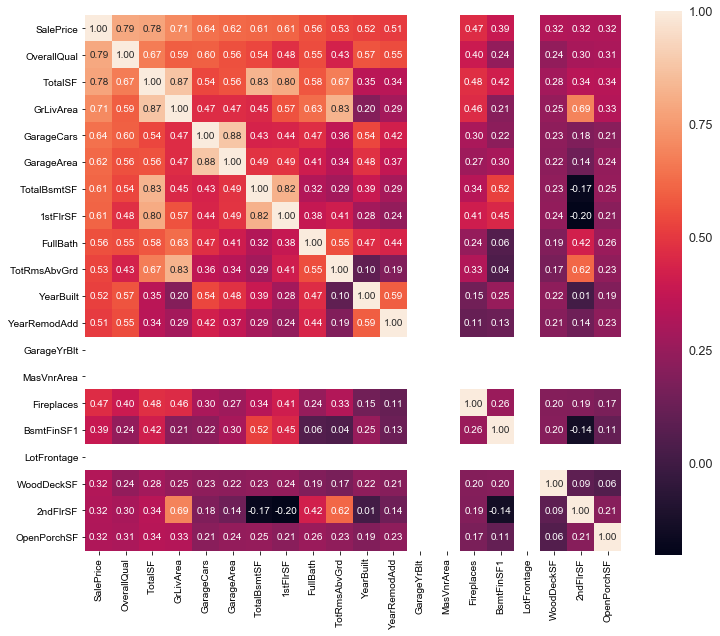

In [4]:
plt.subplots(figsize = (12, 10))

corrmat = df_train.corr()
columns = corrmat.nlargest(20, "SalePrice")["SalePrice"].index
cm = np.corrcoef(df_train[columns].values.T)
sns.set(font_scale = 1.25)

hm = sns.heatmap(cm, square = True, cbar = True, annot = True, fmt='.2f', annot_kws = {'size': 10}, 
                 yticklabels = columns.values, xticklabels = columns.values)
plt.show()

In [5]:
columns

Index(['SalePrice', 'OverallQual', 'TotalSF', 'GrLivArea', 'GarageCars',
       'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd',
       'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'Fireplaces',
       'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF'],
      dtype='object')

De estas variables por colinealidad voy a eliminar: GarageArea, TotalBsmtSF, 1stFlrSF, TotRmsAbvGrd, GarageYrBlt

Y voy a añadir Neighborhood para luego rellenar NaN de la variable LotFrontage

In [6]:
columns = ['SalePrice', 'OverallQual', 'TotalSF', 'GrLivArea', 'GarageCars', 'FullBath', 'YearBuilt', 'YearRemodAdd',  
           'MasVnrArea', 'Fireplaces', 'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', "Neighborhood"]

In [7]:
df_train = df_train[columns]

In [8]:
df_train.head()

,SalePrice,OverallQual,TotalSF,GrLivArea,GarageCars,FullBath,YearBuilt,YearRemodAdd,MasVnrArea,Fireplaces,BsmtFinSF1,LotFrontage,WoodDeckSF,2ndFlrSF,OpenPorchSF,Neighborhood
0,208500,7,2566,1710,2,2,2003,2003,196.0,0,706,65.0,0,854,61,CollgCr
1,181500,6,2524,1262,2,2,1976,1976,0.0,1,978,80.0,298,0,0,Veenker
2,223500,7,2706,1786,2,2,2001,2002,162.0,1,486,68.0,0,866,42,CollgCr
3,140000,7,2473,1717,3,1,1915,1970,0.0,1,216,60.0,0,756,35,Crawfor
4,250000,8,3343,2198,3,2,2000,2000,350.0,1,655,84.0,192,1053,84,NoRidge


Vamos a ver los Outliers

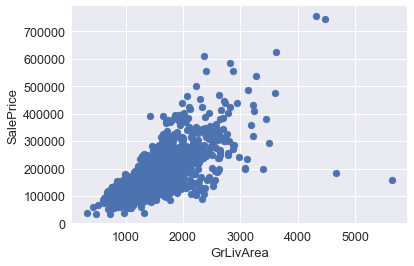

In [9]:
fig = plt.scatter(x = df_train["GrLivArea"], y = df_train["SalePrice"])

plt.ylabel("SalePrice", fontsize = 13)
plt.xlabel("GrLivArea", fontsize = 13)

plt.show()

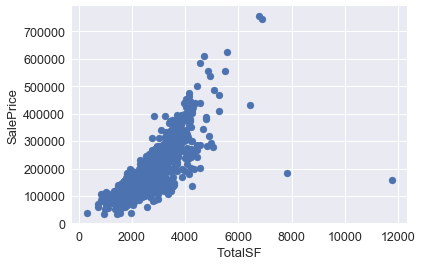

In [10]:
fig = plt.scatter(x = df_train["TotalSF"], y = df_train["SalePrice"])

plt.ylabel("SalePrice", fontsize = 13)
plt.xlabel("TotalSF", fontsize = 13)

plt.show()

In [11]:
df_train[(df_train["GrLivArea"] > 4000) & (df_train["SalePrice"] < 300000)]

,SalePrice,OverallQual,TotalSF,GrLivArea,GarageCars,FullBath,YearBuilt,YearRemodAdd,MasVnrArea,Fireplaces,BsmtFinSF1,LotFrontage,WoodDeckSF,2ndFlrSF,OpenPorchSF,Neighborhood
523,184750,10,7814,4676,3,3,2007,2008,762.0,1,2260,130.0,208,1538,406,Edwards
1298,160000,10,11752,5642,2,2,2008,2008,796.0,3,5644,313.0,214,950,292,Edwards


Me salen en los dos los mismos casos, los voy a eliminar

In [12]:
df_train = df_train.drop(df_train[df_train.index == 523].index)
df_train = df_train.drop(df_train[df_train.index == 1298].index)

Ahora voy a normalizar algunas variables, esta vez no únicamente SalePrice

In [13]:
df_train["SalePrice"] = np.log(df_train["SalePrice"])

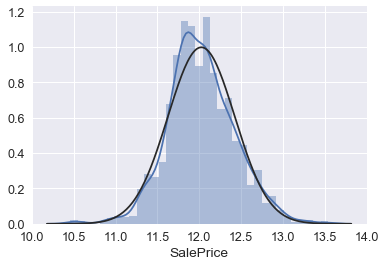

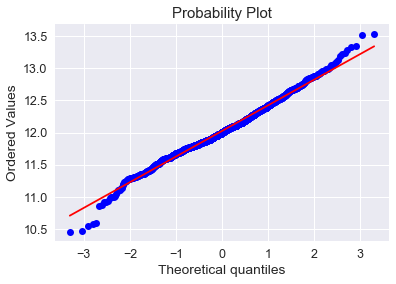

In [14]:
sns.distplot(df_train["SalePrice"], fit = norm);
fig = plt.figure()
res = stats.probplot(df_train["SalePrice"], plot = plt)

In [15]:
df_train["GrLivArea"] = np.log(df_train["GrLivArea"])

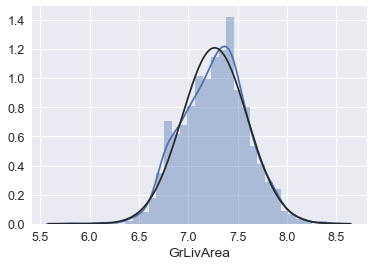

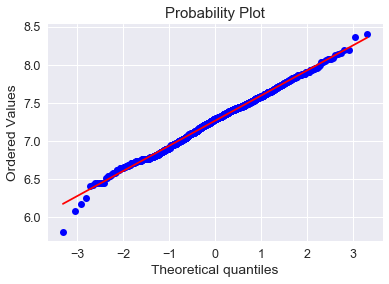

In [16]:
sns.distplot(df_train["GrLivArea"], fit = norm);
fig = plt.figure()
res = stats.probplot(df_train["GrLivArea"], plot = plt)

In [17]:
df_train["TotalSF"] = np.log(df_train["TotalSF"])

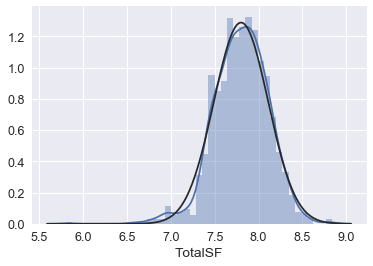

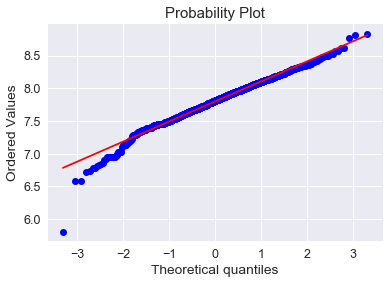

In [18]:
sns.distplot(df_train["TotalSF"], fit = norm);
fig = plt.figure()
res = stats.probplot(df_train["TotalSF"], plot = plt)

Ahora vamos a tratar los missing values

In [19]:
df_train.isnull().sum().sort_values(ascending = False) / len(df_train) * 100

LotFrontage     17.764060
MasVnrArea       0.548697
Neighborhood     0.000000
OpenPorchSF      0.000000
2ndFlrSF         0.000000
WoodDeckSF       0.000000
BsmtFinSF1       0.000000
Fireplaces       0.000000
YearRemodAdd     0.000000
YearBuilt        0.000000
FullBath         0.000000
GarageCars       0.000000
GrLivArea        0.000000
TotalSF          0.000000
OverallQual      0.000000
SalePrice        0.000000
dtype: float64

LotFrontage: Linear feet of street connected to property

Para rellenar los NaN lo que podemos hacer es agrupar las casas por barrio y ver la media de LotFrontage por barrio. Asumo esto porque podemos suponer que las casas del mismo barrio tendrán una LotFrontage similar

In [20]:
df_train["LotFrontage"] = df_train.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

MasVnrArea: Masonry veneer area in square feet

Podemos suponer que si el valor es NaN lo podemos sustituir por cero

In [21]:
df_train["MasVnrArea"] = df_train["MasVnrArea"].fillna(0)

Comprobamos si hay NaN

In [22]:
df_train.isnull().sum().max()

0

Elimino la variable Neighborhood

In [23]:
df_train.drop("Neighborhood", axis = 1, inplace = True)

Vamos a ver la oblicuidad de las variables numéricas

In [24]:
# Check the skew of all numerical features
skewed_feats = df_train.apply(lambda x: skew(x.dropna())).sort_values(ascending = False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MasVnrArea,2.693554
OpenPorchSF,2.337421
LotFrontage,1.546624
WoodDeckSF,1.544214
2ndFlrSF,0.812121
BsmtFinSF1,0.764002
Fireplaces,0.631409
OverallQual,0.200579
SalePrice,0.121443
FullBath,0.031239


Box Cox Transformation of (highly) skewed features

In [25]:
skewness = skewness[abs(skewness["Skew"]) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    df_train[feat] = boxcox1p(df_train[feat], lam)

There are 6 skewed numerical features to Box Cox transform


Este sería nuestro DF definitivo

In [26]:
df_train.head()

,SalePrice,OverallQual,TotalSF,GrLivArea,GarageCars,FullBath,YearBuilt,YearRemodAdd,MasVnrArea,Fireplaces,BsmtFinSF1,LotFrontage,WoodDeckSF,2ndFlrSF,OpenPorchSF
0,12.247694,7,7.850104,7.444249,2,2,2003,2003,8.059126,0,11.170327,5.831328,0.000000,11.686189,5.714669
1,12.109011,6,7.833600,7.140453,2,2,1976,1976,0.000000,1,12.062832,6.221214,9.010206,0.000000,0.000000
2,12.317167,7,7.903227,7.487734,2,2,2001,2002,7.646538,1,10.200343,5.914940,0.000000,11.724598,5.053371
3,11.849398,7,7.813187,7.448334,3,1,1915,1970,0.000000,1,8.274266,5.684507,0.000000,11.354094,4.745132
4,12.429216,8,8.114624,7.695303,3,2,2000,2000,9.391827,1,10.971129,6.314735,8.013884,12.271365,6.314735


Ahora hacemos el modelo

In [27]:
X = df_train.values
y = df_train.SalePrice.values

In [28]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [29]:
def mean_absolute_percentage_error(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true))

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [31]:
xgreg = XGBRegressor(max_depth = 3, n_estimators = 1500)
xgreg.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [32]:
print(np.sqrt(-cross_val_score(xgreg, X, y, scoring = "neg_mean_squared_error", cv = 10).mean()))
print(mean_absolute_percentage_error(np.exp(y_test), np.exp(xgreg.predict(X_test))))
print(np.sqrt(mean_squared_error(np.exp(y), np.exp(xgreg.predict(X)))))

0.00589392893184
0.112940360665
300.974428909


In [33]:
np.exp(xgreg.predict(X))[5:10]

array([ 142724.21875 ,  306115.46875 ,  199954.453125,  130059.125   ,
        118075.671875], dtype=float32)

In [34]:
np.exp(y)[5:10]

array([ 143000.,  307000.,  200000.,  129900.,  118000.])